# FFT Development

# Standard problem

In [44]:
region = df.Region(p1=(0, 0, 0), p2=(120e-9, 120e-9, 10e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

In [45]:
Ms = 800e3
A = 1.3e-11
gyro = 2.210173e5
damp = 0.008
H_mag = 80e3
H_relax = H_mag * np.array([1, 0.715, 0]) / np.linalg.norm([1, 0.715, 0])
H_dyn = H_mag * np.array([1, 0.7, 0]) / np.linalg.norm([1, 0.7, 0])

In [46]:
field = df.Field(mesh=mesh, dim=3, value=(0,0,1), norm=Ms)

C:\Users\samjr_ym2i32\.conda\envs\ubermagdev\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\samjr_ym2i32\.conda\envs\ubermagdev\lib\site-packages\matplotlib\quiver.py:679: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


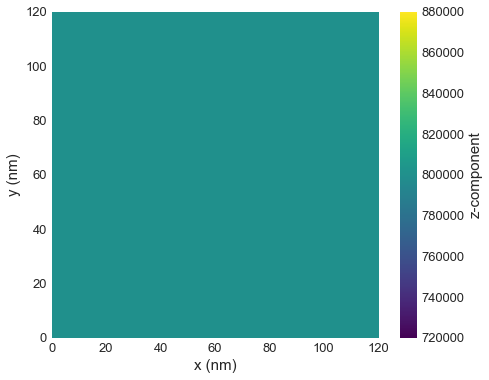

In [47]:
system = mm.System(name='standard_problem')
system.energy = (mm.Exchange(A=A) + 
                 mm.Zeeman(H=H_relax) +
                 mm.Demag())
system.dynamics = mm.Precession(gamma0=gyro) + mm.Damping(alpha=damp)
system.m = field

system.m.plane('z').mpl()

In [48]:
md = mc.MinDriver()
md.drive(system)

Running OOMMF (DockerOOMMFRunner) [2021/08/23 10:29]... (5.0 s)


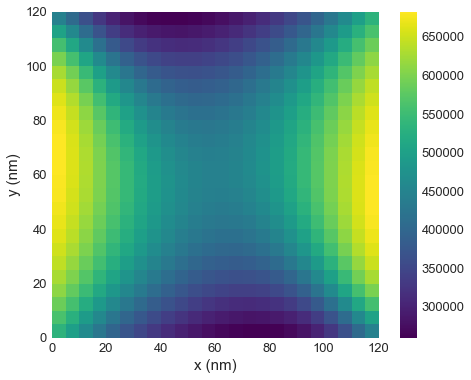

In [49]:
system.m.y.plane('z').mpl()

Dynamics

In [50]:
system.energy.zeeman.H = H_dyn

In [51]:
td = mc.TimeDriver()
td.drive(system, t=20e-9, n=4000)

Running OOMMF (DockerOOMMFRunner) [2021/08/23 10:30]... (264.4 s)


Global

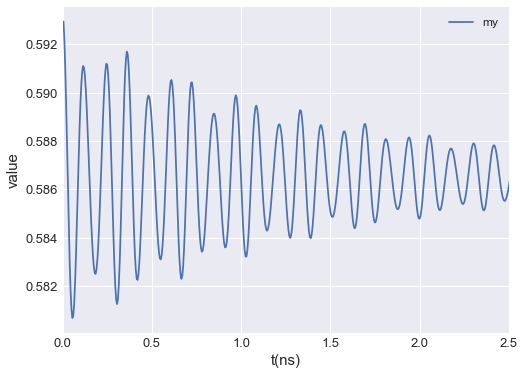

In [58]:
system.table.mpl(y=['my'], xlim=[0, 2.5e-9])

In [2]:
drive = mic_d.Drive(name='standard_problem', number=3)

In [13]:
s_table = drive.table

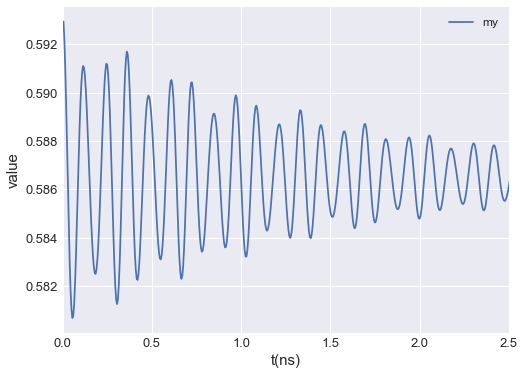

In [14]:
s_table.mpl(y=['my'], xlim=[0,2.5e-9])

In [15]:
ft_table = s_table.rfft(y=['mx', 'my'])

In [60]:
import matplotlib.pyplot as plt
import ubermagtable as ut

In [68]:
ft_table.apply(lambda x: np.abs(x)**2).data.iloc

In [61]:
new_table = ut.Table(data=ft_table.apply(lambda x: np.abs(x)**2).data.iloc[1:], units=ft_table.units, x=ft_table.x)

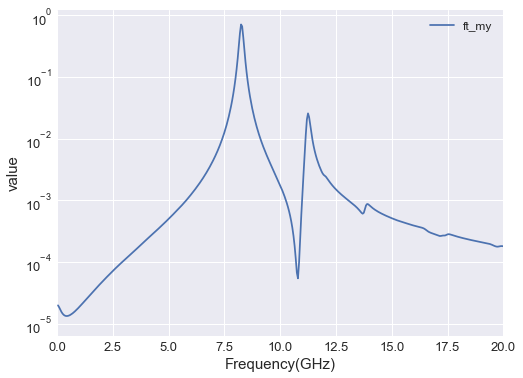

In [67]:
new_table.mpl(y=['ft_my'], xlim=[0, 20e9])
plt.gca().set_yscale('log')

local

In [1]:
import micromagneticdata as mic_d
import numpy as np
import matplotlib.pyplot as plt
import discretisedfield as df
import os
import glob

In [2]:
drive = mic_d.Drive(name='standard_problem', number=3)

In [8]:
drive.path

'./standard_problem\\drive-3'

In [10]:
drive.name

'standard_problem'

In [7]:
drive.__dir__()

['name',
 'number',
 'dirname',
 'path',
 '_x',
 'ft',
 '__module__',
 '__doc__',
 '__init__',
 '__repr__',
 'rfft',
 'irfft',
 'x',
 'info',
 'mif',
 'm0',
 'table',
 'n',
 '_step_files',
 '__getitem__',
 '__iter__',
 'ovf2vtk',
 'slider',
 '__dict__',
 '__weakref__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [ ]:
drive.rfft.['datadir', 'x', 'table', 'n', 'slider', '__getitem__', '__iter__']

In [ ]:
class Drive:
    
    def __init__(self, name, number, dirname='./', x=None)::
        self._magnetisationdata = Spatialdata(datadir='.', x=x)
        pass
    
    def x(self):
        return self._magnetisationdata.x
    
    
    def __getitem__(self, item):
        return self._magnetisationdata[item]
    
    def rfft(self):
        # Comupte rfft and save to disk if not exsisting.
        return Spatialdata(datadir='./Fourier')
    
    def irfft(self):
        # Comupte irfft and save to disk if not exsisting.
        return Spatialdata(datadir='./inv_Fourier')
    

In [ ]:
class Spatialdata:
    
    def __init__(self, datadir, x):
        self.datadir = datadir
        self.x = x
        pass
    
    @property
    def x(self):
        pass  # Inedpendent variable
    
    # x.setter 
    
    @property
    def table(self):
        pass
    
    @property
    def n(self):
        pass
    
    def slider(self):
        pass
    
    def __getitem__(self, item):
        return df.Field.fromfile(filename=list(self._step_files)[item]) # field of an individual step.
    
    def __iter__(self):
        pass  # This iterator iterates through all fields
    
    def 

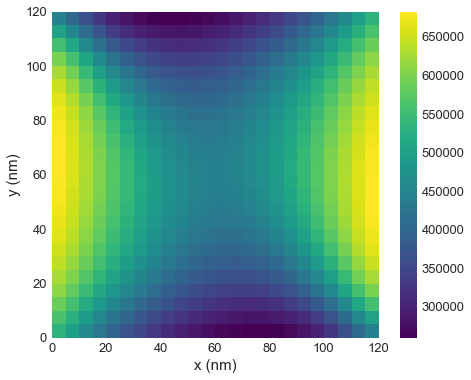

In [3]:
drive[0].y.plane('z').mpl()

In [4]:
ft_drive = drive.rfft()

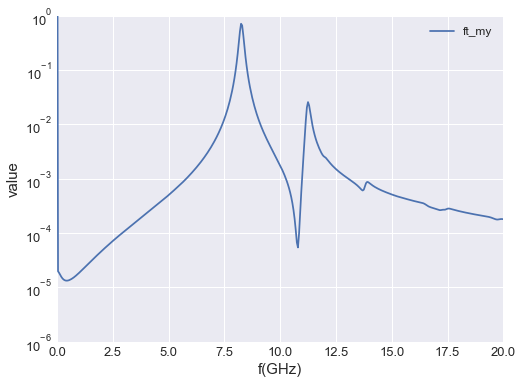

In [5]:
fig, ax = plt.subplots()
ft_drive.table.apply(lambda x: np.abs(x)**2).mpl(y=['ft_my'], xlim=[0, 20e9], ax=ax)
plt.gca().set_ylim([1e-6, 1])
plt.gca().set_yscale('log')

In [6]:
s_l = []
for ft_field in ft_drive:
    s_l.append(np.power((np.abs(ft_field)), 2).average)  # np.abs not abs() as want each component seperatly
s_l = np.array(s_l)

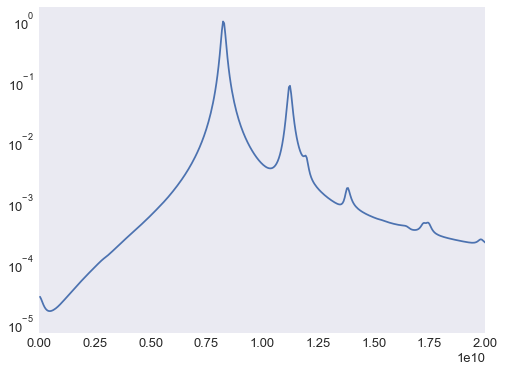

In [8]:
plt.plot(ft_drive.table.data['f'].values[1:], s_l[1:,1]/(800e3**2))
plt.xlim([0, 20e9])
plt.yscale("log")

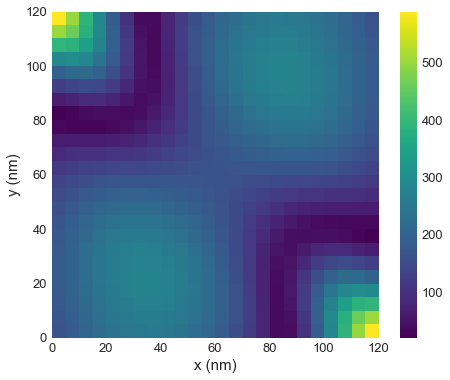

In [12]:
idx = abs(ft_drive.table.data['f'].values - 11.25e9).argmin()
(np.abs(ft_drive[idx].y)).plane('z').mpl()

In [13]:
ift_drive = ft_drive.irfft()

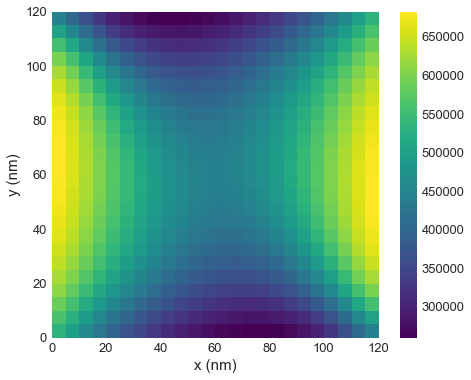

In [14]:
ift_drive[0].y.plane('z').mpl()

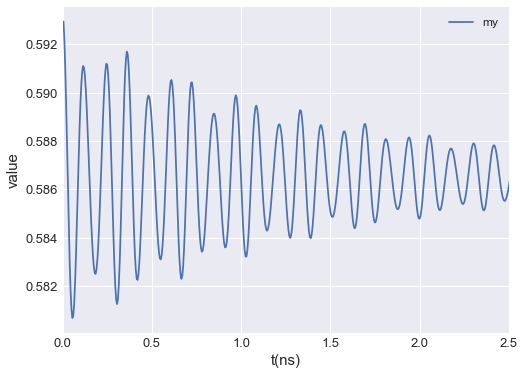

In [25]:
ift_drive.table.mpl(y=['my'], xlim=[0, 2.5e-9])